# NYC fare prediction

[This notebook](TBD) shows my approach for predicting the fare amount for a taxi ride in NYC when given the pickup and dropoff locations of the passangers regarding the [New York City Taxi Fare Prediction Challange]( https://www.kaggle.com/c/new-york-city-taxi-fare-prediction).



---

This notebook is seperated into different sections, relating to the common data science workflow (except the hypothesis and data collection where already done).


0.   Previous Commits
1.   Setup and Check Infrastructure
2.   Having a first look at the Data (EDA)
3.   Data Cleaning (Feature Engineering)
4.   Linear Regression
5.   Ridge Regression
6.   Model ...
7.   Evaulation and Discussion

---



# 0. Previous Commits - Comparison of different Models:



Predictions are done when using the whole data set

### Linear Regression

**Commit 1 (Baseline) Score: 5.67093**
- 5.67093
 

### Ridge Regression

**Commit 2 Score: 12.54277**

params_ridge
  - alpha = loguniform(1e-5, 1e0)
  - solver = ['eig', 'cd']
  - n_iter = 100
  - cv = 5
  - verbose = 0
  - n_jobs = 1

ridge_params
  - alpha = 0.240960447726532
  - fit_intercept = True
  - normalize = False
  - solver = 'eig'

RMSE for Ridge_rmse Regression is  -7.212150573730469


### K-Nearest Neighbor 
**Commit 3 Score: 4.86790**
  - n_neighbors = 4
  - data_size = 5.5 Mio rows (1 %)

### Random Forest 
**Commit 4 Score: 5.95518**
  - n_estimators=10
  - n_jobs=-1
  - data_size = 1 Mio. rows

### XG Boost (GPU)
**Commit 5 Score: 3.98546**
  - n_estimators':500, # 200?
  - max_depth':7,
  - learning_rate':0.0005, # 0.007
  - subsample':0.9,
  - colsample_bytree':0.9,
  - missing':-999,
  - random_state':2020,
  - objective':'reg:linear',
  - gamma':0.3,
  - reg_alpha':0.01,
  - tree_method':'gpu_hist'  # THE MAGICAL PARAMETER

  - data_size = 7 Mio. rows




# 1. Setup and Check Infrastructure

If you find yourself running these notebooks on Colab as well as on Kaggle you might find this placeholder thing helpful. Only thing to touch ist the environment you are running on (Kaggle or Colab)

In [6]:
## Switch from Kaggle to Colab easily
environment='Colab'

## when True only 50.000 rows are used for debugging purpose. Set to False when doing real training
debug_mode=True 

## choose how many rows of the training data sample you would like to use (only works when debug_mode=False ), max is 55423480
rows_datasample=5542348

In [7]:
if environment == 'Kaggle':
  env_submission_path='./'
  env_path='../input/new-york-city-taxi-fare-prediction/'
  print('The environment and paths were successfully setup for Kaggle')
elif environment == 'Colab':
  env_submission_path='/content/drive/My Drive/Colab Notebooks/'
  env_path='/content/drive/My Drive/Colab Notebooks/'

  from google.colab import drive
  drive.mount('/content/drive')

  print('The environment and paths were successfully setup for Colab')

else:
  print('Something went wrong here, please choose one of the options for path completion: Kaggle or Colab (or implement your own thing)')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The environment and paths were successfully setup for Colab


Check for GPU

In [8]:
!nvidia-smi

Sun Sep 27 13:20:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!lscpu | grep "Model name:"
!lscpu | grep "CPU(s)"

Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
CPU(s):              2
On-line CPU(s) list: 0,1
NUMA node0 CPU(s):   0,1


In [10]:
if environment == 'Kaggle':
  import sys
  !cp ../input/rapids/rapids.0.14.0 /opt/conda/envs/rapids.tar.gz
  !cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
  sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
  sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
  sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
  !cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/
  print('You are all set for the kaggle rapids environment')

elif environment == 'Colab':
  # Install RAPIDS and Dask_ml
  !pip install dask_ml
  !pip install dask_cuda
  !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
  !bash rapidsai-csp-utils/colab/rapids-colab.sh stable

  import sys, os
  dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
  sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
  sys.path
  exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())
  print('You are all set for the colab rapids environment')

else:
  print('Something went wrong here, please choose one of the options for path completion: Kaggle or Colab (or implement your own thing). If Kaggle failed please make sure you added the RAPIDS file on Kaggle to your Input!')

  Using cached dask_ml-1.7.0-py3-none-any.whl (141 kB)
  Using cached dask_glm-0.2.0-py2.py3-none-any.whl (12 kB)
  Using cached multipledispatch-0.6.0-py3-none-any.whl (11 kB)
  Using cached dask_cuda-0.15.0-py3-none-any.whl (44 kB)
fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils

In [11]:
import nvstrings
import numpy as np
import cudf, cuml
import dask_cudf
import io, requests
import math
import gc
import cupy as cp
import pandas as pd

import time 
import itertools

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns 

#Learning
from cuml.preprocessing.model_selection import train_test_split
from scipy.stats import uniform

# Linear Models https://github.com/rapidsai/cuml/tree/branch-0.13/notebooks
from cuml.linear_model import LinearRegression # Linear
from cuml.linear_model import LogisticRegression # Logisitc
from cuml.linear_model import ElasticNet # Elastic
from cuml.linear_model import Ridge # Ridge
from cuml.linear_model import Lasso # Lasso
from cuml.linear_model import MBSGDRegressor as cumlMBSGDRegressor # Mini Batch SGD Regressor

from cuml.solvers import SGD as cumlSGD # Stochastic Gradient Descent
from cuml.ensemble import RandomForestRegressor as cuRF # Random Forest
from cuml.dask.ensemble import RandomForestClassifier as cumlDaskRF # RandomForest

from cuml.neighbors import KNeighborsRegressor as cumlKNR # Nearest Neighbours
from cuml.svm import SVC # Support Vector Machines

from cuml import ForestInference
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from cuml.metrics.regression import r2_score
from cuml.metrics.accuracy import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score as sk_acc
from sklearn.utils.fixes import loguniform

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: nvstrings will be removed in 0.15. Please use equivalent from libcudf
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
#!pip install -U xgboost
!pip install dask-xgboost
import dask_xgboost as dxgb

import dask; print('Dask Version:', dask.__version__)

from dask.distributed import Client
from dask_cuda import LocalCUDACluster

Dask Version: 2.28.0


In [14]:
#!pip install -U xgboost
!pip install dask-xgboost
import dask_xgboost as dxgb

import dask; print('Dask Version:', dask.__version__)

from dask.distributed import Client
from dask_cuda import LocalCUDACluster

# create a local cluster with 4 workers
n_workers = 1
# create a local CUDA cluster
cluster = LocalCUDACluster()
client = Client(cluster)
client

from dask.delayed import delayed

import dask.dataframe as dd
import dask.array as da

import cudf; print('cuDF Version:', cudf.__version__)
import numpy as np; print('NumPy Version:', np.__version__)

Dask Version: 2.28.0
cuDF Version: 0.14.0
NumPy Version: 1.18.5


/usr/local/lib/python3.6/site-packages/distributed/client.py:1130: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.18.5 | 1.18.5    | 1.19.1  |
| tornado | 5.1.1  | 5.1.1     | 6.0.4   |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [46]:
def save_model_csv(y_pred, csv_name):
  save_submission = submission
  save_submission['fare_amount']=y_pred
  save_submission.to_csv(env_submission_path+csv_name, index=False)
  return save_submission.head(2)

In [100]:
def calc_RMSE(y_pred, model_name):
  score = r2_score(y_pred, y_test)
  print("RMSE for the "+model_name+" model is: ",score)
  return score

# 2. First look at the Data

In [57]:
cudf.set_allocator("managed")
dtype = {'fare_amount': 'float32',
              'pickup_datetime':'str',
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'int8'}

usecols = list(dtype.keys())

In [58]:
%%time
# use a subset with 50.000 rows, max is nrows = 55423480

if debug_mode != True:
  ## using 1% (or how much you like)
  nrwos=rows_datasample
else:
  ## using a very small sample just for testing
  nrows = 50000

test = cudf.read_csv(env_path+'test.csv', usecols=usecols, dtype=dtype)
train = cudf.read_csv(env_path+'train.csv', nrows=nrows, usecols=usecols, dtype=dtype)
submission = cudf.read_csv(env_path+'sample_submission.csv', usecols=usecols, dtype=dtype)

CPU times: user 49 ms, sys: 39 ms, total: 88 ms
Wall time: 814 ms


In [59]:
train.head(5)

fare_amount          pickup_datetime  ...  dropoff_latitude  passenger_count
0          4.5  2009-06-15 17:26:21 UTC  ...         40.712273                1
1         16.9  2010-01-05 16:52:16 UTC  ...         40.782005                1
2          5.7  2011-08-18 00:35:00 UTC  ...         40.750565                2
3          7.7  2012-04-21 04:30:42 UTC  ...         40.758095                1
4          5.3  2010-03-09 07:51:00 UTC  ...         40.783768                1

[5 rows x 7 columns]

In [60]:
test.head(5)

pickup_datetime  pickup_longitude  ...  dropoff_latitude  passenger_count
0  2015-01-27 13:08:24 UTC        -73.973320  ...         40.743835                1
1  2015-01-27 13:08:24 UTC        -73.986862  ...         40.739197                1
2  2011-10-08 11:53:44 UTC        -73.982536  ...         40.746140                1
3  2012-12-01 21:12:12 UTC        -73.981163  ...         40.751633                1
4  2012-12-01 21:12:12 UTC        -73.966042  ...         40.744431                1

[5 rows x 6 columns]

# 3. Data Cleaning

In [61]:
#Drop Nan Values
train.nans_to_nulls()
train = train.dropna()

In [62]:
#Checking shape of the data
print("Train: " + str(train.shape))
print("Test: " + str(test.shape))

Train: (50000, 7)
Test: (9914, 6)


In [63]:
#Changing the data format of pickup_datetime and adding additional information about pickup time
train['pickup_datetime'] = train['pickup_datetime'].astype('datetime64[ns]')

train["hour"] = train.pickup_datetime.dt.hour
train["weekday"] = train.pickup_datetime.dt.weekday
train["month"] = train.pickup_datetime.dt.month
train["year"] = train.pickup_datetime.dt.year


test['pickup_datetime'] = test['pickup_datetime'].astype('datetime64[ns]')

test["hour"] = test.pickup_datetime.dt.hour
test["weekday"] = test.pickup_datetime.dt.weekday
test["month"] = test.pickup_datetime.dt.month
test["year"] = test.pickup_datetime.dt.year

In [64]:
#calculate trip distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [65]:
train['distance'] = distance(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'], train['dropoff_longitude'] )
test['distance'] = distance(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'] )
train['distance'].describe()

count    50000.000000
mean        11.298307
std        220.947550
min          0.000000
25%          0.000000
50%          1.366828
75%          2.424817
max       5385.932617
Name: distance, dtype: float64

In [66]:
#check if everything worked
train.head(10)

fare_amount     pickup_datetime  pickup_longitude  ...  month  year  distance
0          4.5 2009-06-15 17:26:21        -73.844307  ...      6  2009  0.000000
1         16.9 2010-01-05 16:52:16        -74.016045  ...      1  2010  5.244397
2          5.7 2011-08-18 00:35:00        -73.982742  ...      8  2011  0.000000
3          7.7 2012-04-21 04:30:42        -73.987137  ...      4  2012  1.932986
4          5.3 2010-03-09 07:51:00        -73.968102  ...      3  2010  1.366828
5         12.1 2011-01-06 09:50:45        -74.000969  ...      1  2011  2.425102
6          7.5 2012-11-20 20:35:00        -73.980003  ...     11  2012  0.000000
7         16.5 2012-01-04 17:22:00        -73.951302  ...      1  2012  2.480990
8          9.0 2012-12-03 13:10:00        -74.006454  ...     12  2012  0.000000
9          8.9 2009-09-02 01:11:00        -73.980667  ...      9  2009  1.932986

[10 rows x 12 columns]

In [67]:
test.head(2)

pickup_datetime  pickup_longitude  pickup_latitude  ...  month  year  distance
0 2015-01-27 13:08:24        -73.973320        40.763805  ...      1  2015  1.366828
1 2015-01-27 13:08:24        -73.986862        40.719383  ...      1  2015  1.366828

[2 rows x 11 columns]

In [68]:
print("Ararage fare amount: " + str(train['fare_amount'].mean()))
print("Standard deviation fare amount: " + str(train['fare_amount'].std()))
print("Ararage distance: " + str(train['distance'].mean()) + " miles")
print("Standard deviation distance: " + str(train['distance'].std()) + " miles")

Ararage fare amount: 11.364171374445148
Standard deviation fare amount: 9.68555734947306
Ararage distance: 11.298307250665426 miles
Standard deviation distance: 220.94755018686612 miles


In [69]:
train.describe()

fare_amount  pickup_longitude  ...          year      distance
count  50000.000000      50000.000000  ...  50000.000000  50000.000000
mean      11.364171        -72.509757  ...   2011.739260     11.298307
std        9.685557         10.393860  ...      1.862639    220.947550
min       -5.000000        -75.423843  ...   2009.000000      0.000000
25%        6.000000        -73.992058  ...   2010.000000      0.000000
50%        8.500000        -73.981842  ...   2012.000000      1.366828
75%       12.500000        -73.967148  ...   2013.000000      2.424817
max      200.000000         40.783470  ...   2015.000000   5385.932617

[8 rows x 11 columns]

Visualization of the data <br>

The following things were noticed (while using 500k datapoints):
*   The minimal fare_amount is negative. As this does not seem to be realistic I will drop them from the dataset.
*   Some of the minimum and maximum longitude/lattitude coordinates are way off. These  will also be remove from the dataset. (bounding box will be defined)
*   The average fare_amount is about 9.79 USD with a standard deviation of 7.48 USD. When building a predictive model we want to be better than 7.48 USD.



In [70]:
train = train[train.fare_amount>=0]
train = train[(train['distance'] < 30) & (train['distance'] >=0 )]

In [71]:
fare_amount = train['fare_amount'].to_array()
passenger_count = train['passenger_count'].to_array()
distance = train['distance'].to_array()

Text(0.5, 1.0, 'Verteilung des Fahrpreises')

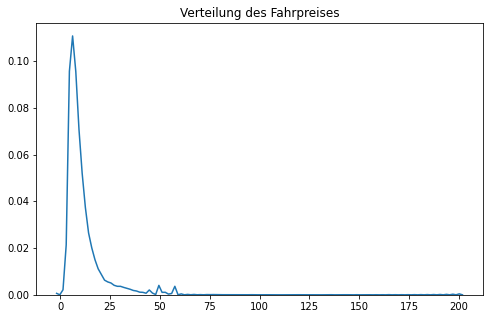

In [72]:
plt.figure(figsize=(8,5))
sns.kdeplot(fare_amount).set_title("Verteilung des Fahrpreises")

Text(0.5, 1.0, 'Distanz')

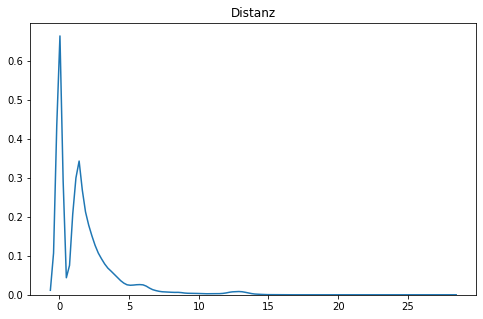

In [73]:
plt.figure(figsize=(8,5))
sns.kdeplot(distance).set_title("Distanz")

In [74]:
#check max latitude und max longitude of test data
print("Max lat pickup: " + str(test['pickup_latitude'].max()))
print("Max lat dropoff: " + str(test['dropoff_latitude'].max()))
print("Max lon pickup: " + str(test['pickup_longitude'].max()))
print("Max lon dropoff: " + str(test['dropoff_longitude'].max()))
print("")
print("Min lat pickup: " + str(test['pickup_latitude'].min()))
print("Min lat dropoff: " + str(test['dropoff_latitude'].min()))
print("Min lon pickup: " + str(test['pickup_longitude'].min()))
print("Min lon dropoff: " + str(test['dropoff_longitude'].min()))

Max lat pickup: 41.709553
Max lat dropoff: 41.696682
Max lon pickup: -72.986534
Max lon dropoff: -72.99096

Min lat pickup: 40.57314
Min lat dropoff: 40.568974
Min lon pickup: -74.25219
Min lon dropoff: -74.26323


Bounding Box New York
<table>
  <tr>
    <th></th>
    <th>Dropoff</th>
    <th>Pickup</th>
  </tr>
  <tr>
    <td>Max Long</td>
    <td>-72.99096</td>
    <td>-72.986534</td>
   </tr>
   <tr>
    <td>Max Lat</td>
    <td>41.696682</td>
    <td>41.709553</td>
   </tr>
   <tr>
    <td>Min Long</td>
    <td>-74.26323</td>
    <td>-74.25219</td>
    </tr>
   <tr>
    <td>Min Lat</td>
    <td>40.568974</td>
    <td>40.57314</td>
   </tr>
</table>



In [75]:
train.head(2)

fare_amount     pickup_datetime  pickup_longitude  ...  month  year  distance
0          4.5 2009-06-15 17:26:21        -73.844307  ...      6  2009  0.000000
1         16.9 2010-01-05 16:52:16        -74.016045  ...      1  2010  5.244397

[2 rows x 12 columns]

In [76]:
#Parts of train data are too far away, so they can be dropped
train = train[(train['pickup_longitude'] > -74.25) & (train['pickup_longitude'] < -72.98)]
train = train[(train['pickup_latitude'] > 40.57) & (train['pickup_latitude'] < 41.70)]
train = train[(train['dropoff_longitude'] < -72.99) & (train['dropoff_longitude'] > -74.26)]
train = train[(train['dropoff_latitude'] > 40.56) & (train['dropoff_latitude'] < 41.69)]

(-74.03, -73.75)

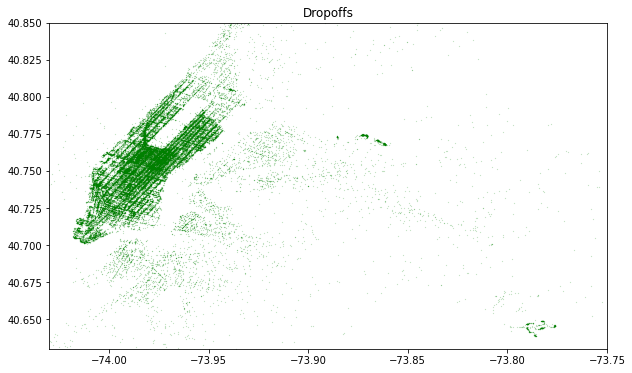

In [77]:
dropoff_longitude = train['dropoff_longitude'].to_array()
dropoff_latitude = train['dropoff_latitude'].to_array()

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

plt.figure(figsize=(10,6))
plt.scatter(dropoff_longitude, dropoff_latitude,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [78]:
unnecessary_columns=['pickup_datetime','dropoff_latitude','pickup_latitude','dropoff_longitude','pickup_longitude']
train=train.drop(unnecessary_columns,axis=1)
test=test.drop(unnecessary_columns,axis=1)

In [79]:
train.head(2)

fare_amount  passenger_count  hour  weekday  month  year  distance
0          4.5                1    17        0      6  2009  0.000000
1         16.9                1    16        1      1  2010  5.244397

In [80]:
test.head(2)

passenger_count  hour  weekday  month  year  distance
0                1    13        1      1  2015  1.366828
1                1    13        1      1  2015  1.366828

In [81]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  39130
Number of records in validation data  9782
(39130, 6)
(9782, 6)
(39130,)
(9782,)


# 4. Linear Regression

In [84]:
lm = LinearRegression(fit_intercept = True, 
                      normalize = False,
                      algorithm = "eig")
lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)

In [44]:
y_pred=lm.predict(test)
y_pred

0       11.054199
1       11.054199
2        4.743408
3       10.214600
4       16.580566
          ...    
9909    11.212646
9910    14.075562
9911    47.265503
9912    23.931030
9913     6.238159
Length: 9914, dtype: float32

In [85]:
score_linear_reg = calc_RMSE(y_pred, 'Linear Regression')

RMSE for the Linear Regression model is:  0.5162847638130188


In [47]:
save_model_csv(y_pred, 'submission_LinearReg')

fare_amount
0    11.054199
1    11.054199

# 5. Ridge Regression

In [48]:
params_ridge = {
    "alpha": loguniform(1e-5, 1e0), # default 1.0
    "solver": ['eig', 'cd'], 
}
ridge = Ridge()
clf = RandomizedSearchCV(ridge, params_ridge, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=1)
best_model = clf.fit(X_train,y_train)

RuntimeError: ignored

In [ ]:
best_model.best_estimator_.get_params()

In [ ]:
ridge_params = {
 'alpha': 0.240960447726532,
 'fit_intercept': True,
 'normalize': False,
 'solver': 'eig'
}

ridge = Ridge(**ridge_params)
result_ridge = ridge.fit(X_train,y_train)

y_pred = result_ridge.predict(X_test)

In [ ]:
ridge_pred = result_ridge.predict(test)

In [ ]:
score_ridge_reg =calc_RMSE(y_pred, 'Ridge Regression')

In [ ]:
save_model_csv(y_pred, 'submission_RidgeReg')

# 6. K-Nearest Neighbors Regression

https://github.com/rapidsai/cuml/blob/branch-0.13/notebooks/kneighbors_regressor_demo.ipynb


In [53]:
## params
n_neighbors=4

In [86]:
## inspiration: https://www.kaggle.com/cdeotte/rapids-knn-30-seconds-0-938/notebook

%%time
knn_cuml = cumlKNR(n_neighbors=n_neighbors)
knn_cuml.fit(X_train, y_train)

cuml_result = knn_cuml.predict(test)

CPU times: user 25.5 ms, sys: 153 ms, total: 179 ms
Wall time: 182 ms


In [90]:
#y_pred=knn_cuml.predict(X_test)

y_pred = knn_cuml.predict(X_test)

In [92]:
score_KNN = = calc_RMSE(y_pred, 'K-nearest Neigbors Regression')

RMSE for the K-nearest Neigbors Regression model is:  0.5071850419044495


In [93]:
save_model_csv(y_pred, 'submission_KNN')

fare_amount
0        5.375
1        5.250

# Random Forest GPU


In [94]:
## params
n_estimators=10
n_jobs=-1

In [95]:
%%time
rf_cuml = cuRF(n_estimators=n_estimators)
rf_cuml.fit(X_train, y_train)

cuRF_result = rf_cuml.predict(test)

CPU times: user 260 ms, sys: 141 ms, total: 402 ms
Wall time: 313 ms


In [97]:
y_pred = rf_cuml.predict(X_test)

In [101]:
score_Rand_For =calc_RMSE(y_pred, 'Random Forest')

RMSE for the Random Forest model is:  0.12264025211334229


0.12264025211334229

In [102]:
save_model_csv(y_pred, 'submission_RandomForest')

fare_amount
0     6.299936
1     5.211668

# XG Boost

In [105]:
params = {
    'max_depth': 7,
    'gamma' :0,
    'eta':.03, 
    'subsample': 1,
    'colsample_bytree': 0.9, 
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 0
}

params_1 = {
    'n_estimators':500, # 200?
    'max_depth':7,
    'learning_rate':0.0005, # 0.007
    'subsample':0.9,
    'colsample_bytree':0.9,
    'missing':-999,
    'random_state':2020,
    'objective':'reg:linear',
    'gamma':0.3,
    'reg_alpha':0.01,
    'tree_method':'gpu_hist'  # THE MAGICAL PARAMETER
}

## https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters
#set parameters for xgboost
params_2 = {'max_depth':7,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.05
         }
num_rounds = 50

params_3 = {
    # Parameters that we are going to tune.
    'max_depth': 8, #Result of tuning with CV
    'eta':.03, #Result of tuning with CV
    'subsample': 1, #Result of tuning with CV
    'colsample_bytree': 0.8, #Result of tuning with CV
    # Other parameters
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 1
}

## XG Boost model comparison GPU / CPU

In [103]:
start_time=time.time()
timetaken_gpu_xgb=time.time()-start_time
timetaken_gpu_xgb

2.2172927856445312e-05

Running nicely in Kaggle but not in Colab
- TypeError: can not initialize DMatrix from DataFrame

In [107]:
%%time
def XGBmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params_1,
                    dtrain=matrix_train,num_boost_round=50000, 
                    early_stopping_rounds=100,evals=[(matrix_test,'test')])
    return model

XGB_model = XGBmodel(X_train,X_test,y_train,y_test,params)

TypeError: ignored

- https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.to_delayed

- https://github.com/dask/dask-ml/issues/521

In [ ]:
timetaken_gpu=time.time()-starttime
print("GPU time taken for XG Boost model: ",timetaken_gpu_xgb)

In [54]:
xgb_prediction = XGB_model.predict(xgb.DMatrix(test), ntree_limit = XGB_model.best_ntree_limit).tolist()

In [55]:
y_pred = XGB_model.predict(xgb.DMatrix(X_test))

RMSE for Random Forest is  0.7163589000701904


In [ ]:
score_XGB_GPU = =calc_RMSE(y_pred, 'XGBoost GPU')

In [56]:
save_model_csv(y_pred, 'submission_XGboost_GPU')

## XG Boost Dask model for distributed clients (Not running with one client)

- https://www.kaggle.com/sandeepkumar121995/eda-data-cleaning-xg-boost
- https://www.kaggle.com/gunbl4d3/xgboost-ing-taxi-fares
- https://www.kaggle.com/aerdem4/m5-lofo-importance-on-gpu-via-rapids-xgboost
- https://www.kaggle.com/xhlulu/ieee-fraud-xgboost-with-gpu-fit-in-40s



Running into several problems with XG Boost. Python Kernel stops witout error message 	
- what(): parallel_for failed: cudaErrorNoKernelImageForDevice: no kernel image is available for execution on the device
- https://www.kaggle.com/c/otto-group-product-classification-challenge/discussion/13308
- https://github.com/CannyLab/tsne-cuda/issues/18

Hypothesis: There could be an error when loading a cudf dataset in XGBoost. Seems to not happen when using pandas

In [106]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  39130
Number of records in validation data  9782
(39130, 6)
(9782, 6)
(39130,)
(9782,)


In [110]:
y_train['fare_amount']

TypingError: ignored

Error when using evals, turning it off results in Value Error. Not possible to convert matrix_test to something running, tested with pandas df, cudf, numpy. NaN cleanup again, still...
- https://github.com/dmlc/xgboost/issues/2274
- https://github.com/rapidsai/cudf/issues/2892

In [123]:
%%time
def dask_XGBmodel(X_train,X_test,y_train,y_test,params):
    #matrix_test = xgb.DMatrix(data=dd.from_pandas(X_test.to_pandas(),1), label=dd.from_pandas(y_test.to_pandas(), 1))

    #Drop Nan Values
    X_test.nans_to_nulls()
    X_test = X_test.dropna()

    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model = dxgb.train(client, params=params, 
                       data=dd.from_pandas(X_train, 1), 
                       labels=dd.from_pandas(y_train, 1), 
                       num_boost_round=5000,
                       early_stopping_rounds=10,
                       evals=[(matrix_test,'test')]
                      )
    return model

dask_XGB_model = dask_XGBmodel(X_train,X_test,y_train,y_test,params)

#y_pred = dask_XGB_model.predict(testDGX)

ValueError: ignored

# LGBM model (not working)

- https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

- https://www.kaggle.com/nicapotato/taxi-rides-time-analysis-and-oof-lgbm

- https://www.kaggle.com/dsaichand3/lgbm-gpu

- https://www.kaggle.com/aerdem4/rapids-svm-on-trends-neuroimaging


Compared CPU vs GPU:
- https://www.kaggle.com/ishivinal/sklearn-rapids-pandas


## Setup LGBM with GPU Support

How to setup LGBM GPU Beta:
- https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm


In [57]:
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM
!apt-get install -y -qq libboost-all-dev

rm: cannot remove '/opt/conda/lib/python3.6/site-packages/lightgbm': No such file or directory
Cloning into 'LightGBM'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 19581 (delta 67), reused 5 (delta 0), pack-reused 19463
Receiving objects: 100% (19581/19581), 15.67 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (14286/14286), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 2.91 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'


In [58]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - not found
-- Looking for CL_VERSION_2_1
-- Looking for CL_VERSION_2_1 - not found
-- Looking for CL_VERSION_2_0
-- Looking for CL_VERSION_2_0 - not found
-- Looking for CL_VERSION_1_2
-- Looking

rm: cannot remove 'build': No such file or directory
CMakeFiles/lightgbm.dir/src/treelearner/gpu_tree_learner.cpp.o: In function `boost::compute::detail::program_binary_path(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, bool)':
gpu_tree_learner.cpp:(.text._ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb[_ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb]+0x1e5): undefined reference to `boost::filesystem::detail::status(boost::filesystem::path const&, boost::system::error_code*)'
gpu_tree_learner.cpp:(.text._ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb[_ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb]+0x233): undefined reference to `boost::filesystem::detail::create_directories(boost::filesystem::path const&, boost::system::error_code*)

In [59]:
!cd LightGBM/python-package/;python3 setup.py install --precompile
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

running install
running build
running build_py
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
reading manifest file 'lightgbm.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lig

In [60]:
import lightgbm as lgbm

OSError: ignored

In [ ]:
## Inspiration from https://www.kaggle.com/dsaichand3/lgbm-gpu
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.15,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 15,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

In [ ]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
%%time
train_set = lgbm.Dataset(x_train, y_train, silent=False, categorical_feature=['year','month','day'])
valid_set = lgbm.Dataset(x_test, y_test, silent=False, categorical_feature=['year','month','day'])
del x_train, y_train, x_test, y_test
gc.collect()
model = lgbm.train(params, train_set = train_set, num_boost_round=10000, early_stopping_rounds=500, verbose_eval=500, valid_sets=valid_set)

In [ ]:
dataset = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows = 25000000)

In [ ]:
LGBM_pred = model.predict(test, num_iteration = model.best_iteration)

In [ ]:
score_LGBM = =calc_RMSE(y_pred, 'LGBM GPU')

In [ ]:
save_model_csv(y_pred, 'submission_LGBM_GPU')

# 7. Evaluation and Discussion

Show RMSE scores